# Proyecto práctico: 
###- Íñigo Ballester Gúrpide
###- Álvaro Román de Aragón
###- Lucas Werner

Consideraciones a tener en cuenta:

- El entorno sobre el que trabajaremos será _SpaceInvaders-v0_ y el algoritmo que usaremos será _DQN_.

- Para nuestro ejercicio, una solución óptima será alcanzada cuando el agente consiga una **media de recompensa por encima de 20 puntos en modo test**. Por ello, esta media de la recompensa se calculará a partir del código de test en la última celda del notebook.

Este proyecto práctico consta de tres partes:

   1) Implementar la red neuronal que se usará en la solución
    
   2) Implementar las distintas piezas de la solución DQN
    
   3) Justificar la respuesta en relación a los resultados obtenidos

IMPORTANTE:

- Si no se consigue una puntuación óptima, responder sobre la mejor puntuación obtenida.

- Para entrenamientos largos, recordad que podéis usar checkpoints de vuestros modelos para retomar los entrenamientos. En este caso, recordad cambiar los parámetros adecuadamente (sobre todo los relacionados con el proceso de exploración).

- Tened en cuenta que las versiones de librerías recomendadas son Tensorflow==1.13.1, Keras==2.2.4 y keras-rl==0.4.2

### 0) Preparar entorno sobre TF2

Realizamos la conexión con nuestro Google Drive, a fin de almacenar los pesos de los modelos y facilitar el trabajo sobre Colab.:

In [1]:
# Conectamos con nuestro Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Establezco una ruta absoluta a un directorio existente de mi Google Drive (cambiar a drive propio)
BASE_FOLDER = "/content/drive/Othercomputers/My MacBook Pro/08_aprendizaje_por_refuerzo/proyecto/"

Mounted at /content/drive


Instalamos la librería `keras-rl2`, ya preparada para trabajar sobre *Tensorflow 2*, junto con la librería `gym`y la colección de *ROMs* de *Atari*:

In [2]:
# install keras-rl2 that works with tensorflow 2.x
!pip install keras-rl2 > /dev/null 2>&1

# install gym and atari ROMs
!pip install -U gym>=0.21.0
!pip install -U gym[atari,accept-rom-license]

     |████████████████████████████████| 1.6 MB 6.7 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for AutoROM.accept-rom-license: filename=AutoROM.accept_rom_license-0.4.2-py3-none-any.whl size=441026 sha256=73a8c023cede1ad11e98f5c1e92a4195076d4cadd01f4f6aad0bb4e6162138e7
  Stored in directory: /root/.cache/pip/wheels/87/67/2e/6147e7912fe37f5408b80d07527dab807c1d25f5c403a9538a
Successfully built AutoROM.accept-rom-license


Las siguientes librerías nos facilitaran el renderizado y visualización de los episodios de *test* directamente sobre *Google Colab*:

In [3]:
# install the relevant libraries to make rendering possible
!pip install pyvirtualdisplay > /dev/null 2>&1
!apt-get update
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1

Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:3 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release [696 B]
Hit:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release.gpg [836 B]
Hit:7 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:8 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:9 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Get:10 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ Packages [73.9 kB]
Get:11 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:13 https://developer.download.nvi

Importamos una serie de librería básicas, junto con las que nos facilitarán el renderizado sobre *Colab* durante la fase de test:

In [4]:
# import the relevant libraries 
import gym
from gym import logger as gymlogger
from gym.wrappers import Monitor
gymlogger.set_level(40) #error only
import tensorflow as tf
import numpy as np
import math
import glob
import io
import base64
from IPython.display import HTML

from IPython import display as ipythondisplay


/usr/local/lib/python3.7/dist-packages/ale_py/roms/utils.py:90: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for external in metadata.entry_points().get(self.group, []):


Estas funciones facilitarán la creación de un renderizado vídeo de los episodios durante la fase de test:

In [5]:

"""
Utility functions to enable video recording of gym environment and displaying it
To enable video, just do "env = wrap_env(env)""
"""

def show_video():
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else: 
    print("Could not find video")

def wrap_env(env):
  env = Monitor(env, './video', force=True)
  return env

#### Importar librerías específicas para el modelo

In [6]:
from __future__ import division

from PIL import Image
import numpy as np
import gym

from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Convolution2D, Permute, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
import keras.backend as K

from rl.agents.dqn import DQNAgent
from rl.policy import LinearAnnealedPolicy, BoltzmannQPolicy, EpsGreedyQPolicy
from rl.memory import SequentialMemory
from rl.core import Processor
from rl.callbacks import FileLogger, ModelIntervalCheckpoint

#### Configuración base del entorno

In [7]:
INPUT_SHAPE = (84, 84)
WINDOW_LENGTH = 4

env_name = 'SpaceInvaders-v0'
env = gym.make(env_name)

np.random.seed(123)
env.seed(123)
nb_actions = env.action_space.n

Funciones para el procesado y normalización de las imágenes *frame* en cada episodio:

In [8]:
class AtariProcessor(Processor):
    def process_observation(self, observation):
        assert observation.ndim == 3  # (height, width, channel)
        img = Image.fromarray(observation)
        img = img.resize(INPUT_SHAPE).convert('L') # a escala de grises
        processed_observation = np.array(img)
        assert processed_observation.shape == INPUT_SHAPE
        return processed_observation.astype('uint8') # casting a 8 bits

    def process_state_batch(self, batch):
        processed_batch = batch.astype('float32') / 255. # normalizar entre 0 y 1
        return processed_batch

    def process_reward(self, reward):
        return np.clip(reward, -1., 1.) # se acota para que no sea tan sensible a valores extremos

Comprobamos una serie de variables básicas en nuestro entorno, como el número y nombre de las acciones disponibles al agente:

In [9]:
# Acciones disponibles en el entorno
nb_actions = env.action_space.n
nb_actions

6

In [ ]:
# Nombres de las acciones
env.unwrapped.get_action_meanings()

['NOOP', 'FIRE', 'RIGHT', 'LEFT', 'RIGHTFIRE', 'LEFTFIRE']

In [ ]:
# Dimensions de las observaciones del entorno
env.observation_space.shape

(210, 160, 3)

## 1. Implementación de la red neuronal

Implementamos la red neuronal de nuestro modelo, que será la misma que se usará tanto para la *target network* como para la *prediction network*. Se trata de una arquitectura simple CNN con 3 capas convolucionales, y una capa *dense* de 128 neurons tras el *flatten*. La capa de salida es lineal y corresponde al número de acciones, ya que tendrá como salidad las recompensas esperadas a futuro para cada acción:

In [10]:
# Next, we build our model. We use the same model that was described by Mnih et al. (2015).
input_shape = (WINDOW_LENGTH,) + INPUT_SHAPE
model = Sequential()

# segun el backend, se usa un ordenamiento de dimensiones diferente (para tensorflow o theano)
#if K.image_dim_ordering() == 'tf':
if K.image_data_format() == 'channels_last':
    # (width, height, channels)
    model.add(Permute((2, 3, 1), input_shape=input_shape))
#elif K.image_dim_ordering() == 'th':
elif image_data_format() == 'channels_first':
    # (channels, width, height)
    model.add(Permute((1, 2, 3), input_shape=input_shape))
else:
    raise RuntimeError('Unknown image_dim_ordering.')
# conv_1
model.add(Convolution2D(32, (8, 8), strides=(4, 4), padding = 'SAME'))
model.add(Activation('relu'))
# conv_2
model.add(Convolution2D(64, (4, 4), strides=(2, 2), padding = 'SAME'))
model.add(Activation('relu'))
# conv_3
model.add(Convolution2D(64, (3, 3), strides=(1, 1), padding = 'SAME'))
model.add(Activation('relu'))
# FC
model.add(Flatten())
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dense(nb_actions))
model.add(Activation('linear')) # lineal porque son las recompensas esperadas a futuro para cada accion (nb_actions)
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 permute (Permute)           (None, 84, 84, 4)         0         
                                                                 
 conv2d (Conv2D)             (None, 21, 21, 32)        8224      
                                                                 
 activation (Activation)     (None, 21, 21, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 64)        32832     
                                                                 
 activation_1 (Activation)   (None, 11, 11, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 11, 11, 64)        36928     
                                                                 
 activation_2 (Activation)   (None, 11, 11, 64)        0

## 2. Implementación de la solución DQN

### 2.1 Definición y entrenamiento del agente

Definimos el *buffer* de la *replay memory*:

In [11]:
memory = SequentialMemory(limit=1000000, window_length=WINDOW_LENGTH)
processor = AtariProcessor()

Definimos a continuación la *policy* básica a usar durante todo el entrenamiento, en este caso una *policy* de tipo *epsilon-greedy*:

In [12]:
# nb_steps será el tiempo que durará la exploración, antes de pasar a explotación. 
# value_test guarda un pelín de aleatoriedad para minimizar el riesgo de estancamiento en minimos durante el test
# empieza muy aleatorio a 1 (100%) de acciones aleatorias y va decreciendo a más acciones 'predichas/aprendidas'
policy = LinearAnnealedPolicy(EpsGreedyQPolicy(), attr='eps',
                              value_max=1., value_min=.1, value_test=.05,
                              nb_steps=1000000)

Aquí definimos y compilamos nuestro modelo usando la clase específica para DQN disponible desde la librería *keras-rl*:

In [13]:
# recordar que el modelo se 'duplica' uno para target y otro para predicción, ambos idénticos
# gamma es el discount factor de las rewards
# target se actualiza cada 10000 steps
# cada 20 steps, se actualizan los pesos del modelo
dqn = DQNAgent(model=model, nb_actions=nb_actions, policy=policy,
               memory=memory, processor=processor,
               nb_steps_warmup=50000, gamma=.99,
               target_model_update=10000,
               train_interval=20)
dqn.compile(Adam(learning_rate=.00025), metrics=['mae'])

Comenzamos el entrenmiento, incluyendo unos *callbacks* para ir grabando por un lado un *log* en texto que nos permitirá luego visualizar una serie de métricas del entrenamiento, y por otro lado ir volcando de manera regular tanto los pesos intermedios (a fin de poder reanudar entrenamiento en caso de sufrir alguna interrupción), como los pesos finales que podremos usar luego durante la fase de tests:

In [13]:
# Training part
# log en pantalla cada 10,000 steps
# cada 250000 steps almaceno versiones del modelo (callbacks)
# el log escrito, cada 100 steps
weights_filename = BASE_FOLDER+'dqn7_{}_weights.h5f'.format(env_name)
checkpoint_weights_filename = BASE_FOLDER+'dqn7_' + env_name + '_weights_{step}.h5f'
log_filename = BASE_FOLDER+'dqn7_{}_log.json'.format(env_name)
callbacks = [ModelIntervalCheckpoint(checkpoint_weights_filename, interval=500000)]
callbacks += [FileLogger(log_filename, interval=100)]

dqn.fit(env, callbacks=callbacks, nb_steps=2000000, log_interval=10000, visualize=False)

dqn.save_weights(weights_filename, overwrite=True)

Training for 1750000 steps ...
Interval 1 (0 steps performed)


/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


10000/10000 [==============================] - 55s 5ms/step - reward: 0.0139
15 episodes - episode_reward: 8.867 [4.000, 25.000] - lives: 2.122

Interval 2 (10000 steps performed)
10000/10000 [==============================] - 46s 5ms/step - reward: 0.0143
14 episodes - episode_reward: 10.143 [4.000, 20.000] - lives: 2.213

Interval 3 (20000 steps performed)
10000/10000 [==============================] - 46s 5ms/step - reward: 0.0142
13 episodes - episode_reward: 11.462 [6.000, 23.000] - lives: 2.017

Interval 4 (30000 steps performed)
10000/10000 [==============================] - 46s 5ms/step - reward: 0.0152
15 episodes - episode_reward: 9.333 [4.000, 18.000] - lives: 2.090

Interval 5 (40000 steps performed)
10000/10000 [==============================] - 62s 6ms/step - reward: 0.0143
14 episodes - episode_reward: 10.786 [3.000, 22.000] - lives: 2.227

Interval 6 (50000 steps performed)
10000/10000 [==============================] - 84s 8ms/step - reward: 0.0139
13 episodes - episod

### 2.2 Testeando nuestro modelo

Creamos un *display virtual* sobre Google Colab, en el cual proyectaremos los *frames* renderizados durante la fase de test

In [14]:
# use PyvirtualDisplay to create a “virtual display” that we will send our rendered frames to
from pyvirtualdisplay import Display
display = Display(visible=0, size=(1400, 900))
display.start()

Envolvemos un *monitor* sobre nuestro entorno:

In [15]:
# wrap a Monitor around environment
env_monitor = wrap_env(env)

Cargamos los pesos guardados durante el entrenamiento y realizamos test de 10 episodios. Los *frames* de cada episodio se van almacenando a fin de ser reproducidos como un pequeño vídeo directamente sobre Colab, en donde podemos comprobar visualmente el desempeño de nuestro agente ya entrenado:

In [29]:
# Testing part to calculate the mean reward
weights_filename = BASE_FOLDER+'dqn7_{}_weights.h5f'.format(env_name)
dqn.load_weights(weights_filename)
test_data = dqn.test(env_monitor, nb_episodes=10, visualize=True)
print(np.mean(test_data.history['episode_reward']))
show_video()

Testing for 10 episodes ...
Episode 1: reward: 30.000, steps: 1157
Episode 2: reward: 19.000, steps: 739
Episode 3: reward: 16.000, steps: 666
Episode 4: reward: 14.000, steps: 633
Episode 5: reward: 12.000, steps: 707
Episode 6: reward: 27.000, steps: 1073
Episode 7: reward: 20.000, steps: 695
Episode 8: reward: 26.000, steps: 956
Episode 9: reward: 23.000, steps: 949
Episode 10: reward: 20.000, steps: 693
20.7


### 2.2 Gráficas del entrenamiento

Cargamos en un *dataframe* el archivo *log* generado durante el entrenamiento, a fin de poder visualizar una serie de métricas en las que podremos apreciar el proceso de aprendizaje:

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

json_filename = BASE_FOLDER+'dqn7_SpaceInvaders-v0_log.json'
df = pd.read_json(json_filename)
df.head()

,loss,mae,mean_q,mean_eps,episode_reward,nb_episode_steps,nb_steps,episode,duration
0,NaN,NaN,NaN,NaN,6,414,414,0,9.032557
1,NaN,NaN,NaN,NaN,7,561,975,1,2.016543
2,NaN,NaN,NaN,NaN,16,977,1952,2,3.675545
3,NaN,NaN,NaN,NaN,1,520,2472,3,1.831401
4,NaN,NaN,NaN,NaN,7,630,3102,4,2.208207


### 2.2.1 Número de pasos / episodio

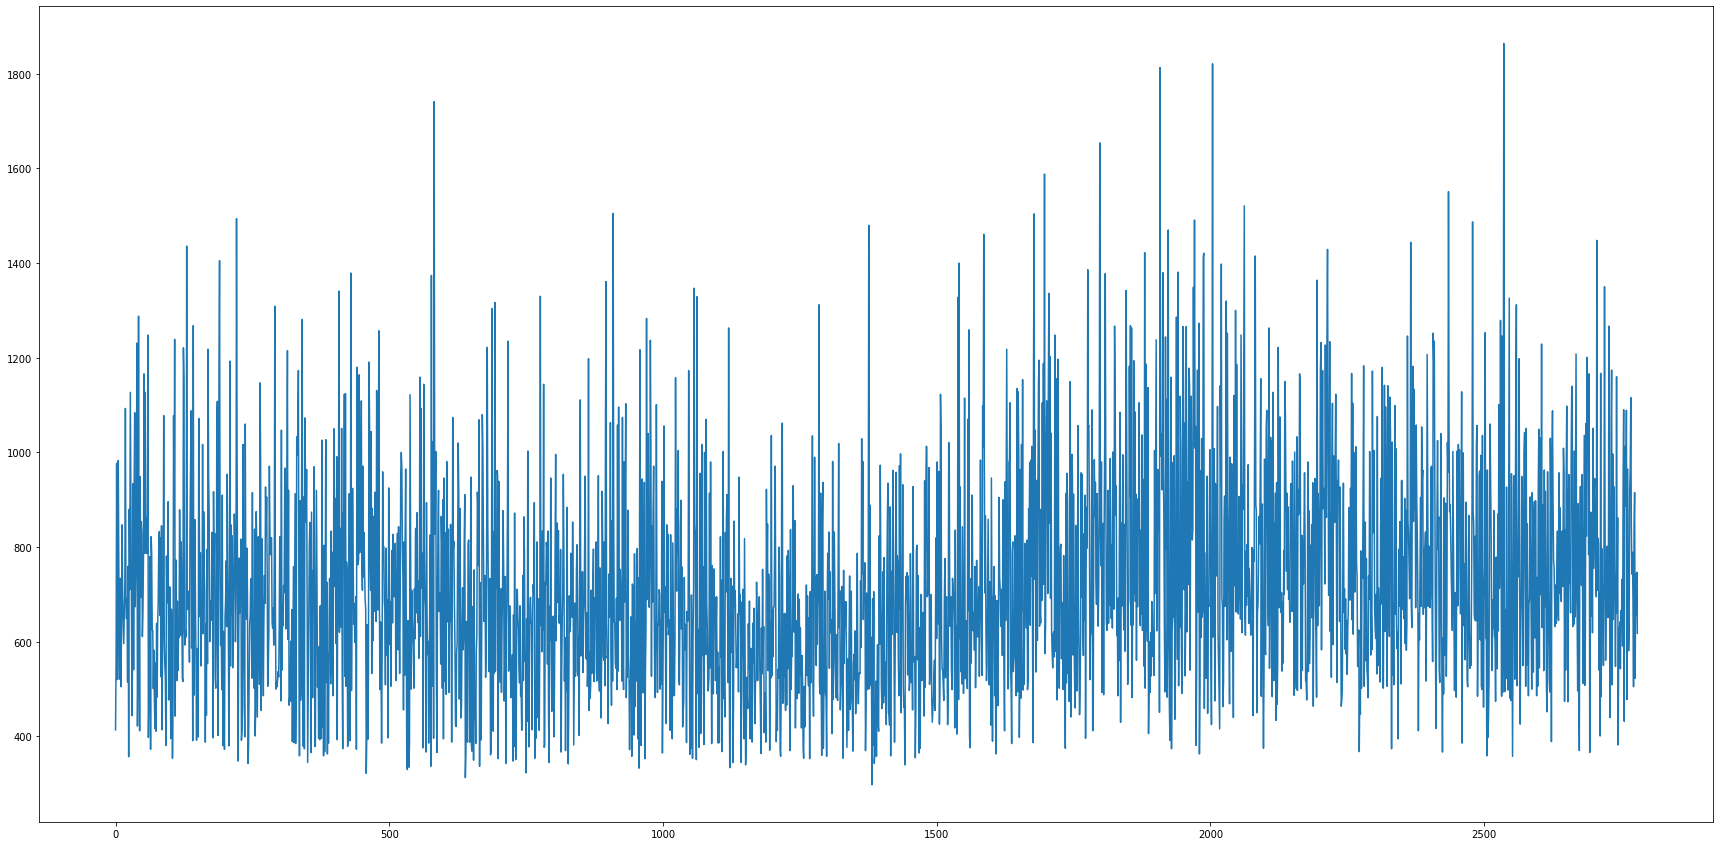

In [ ]:
plt.figure(figsize=(30, 15))
df["nb_episode_steps"].astype(int).plot()

### 2.2.2 Tiempo de partida / episodios

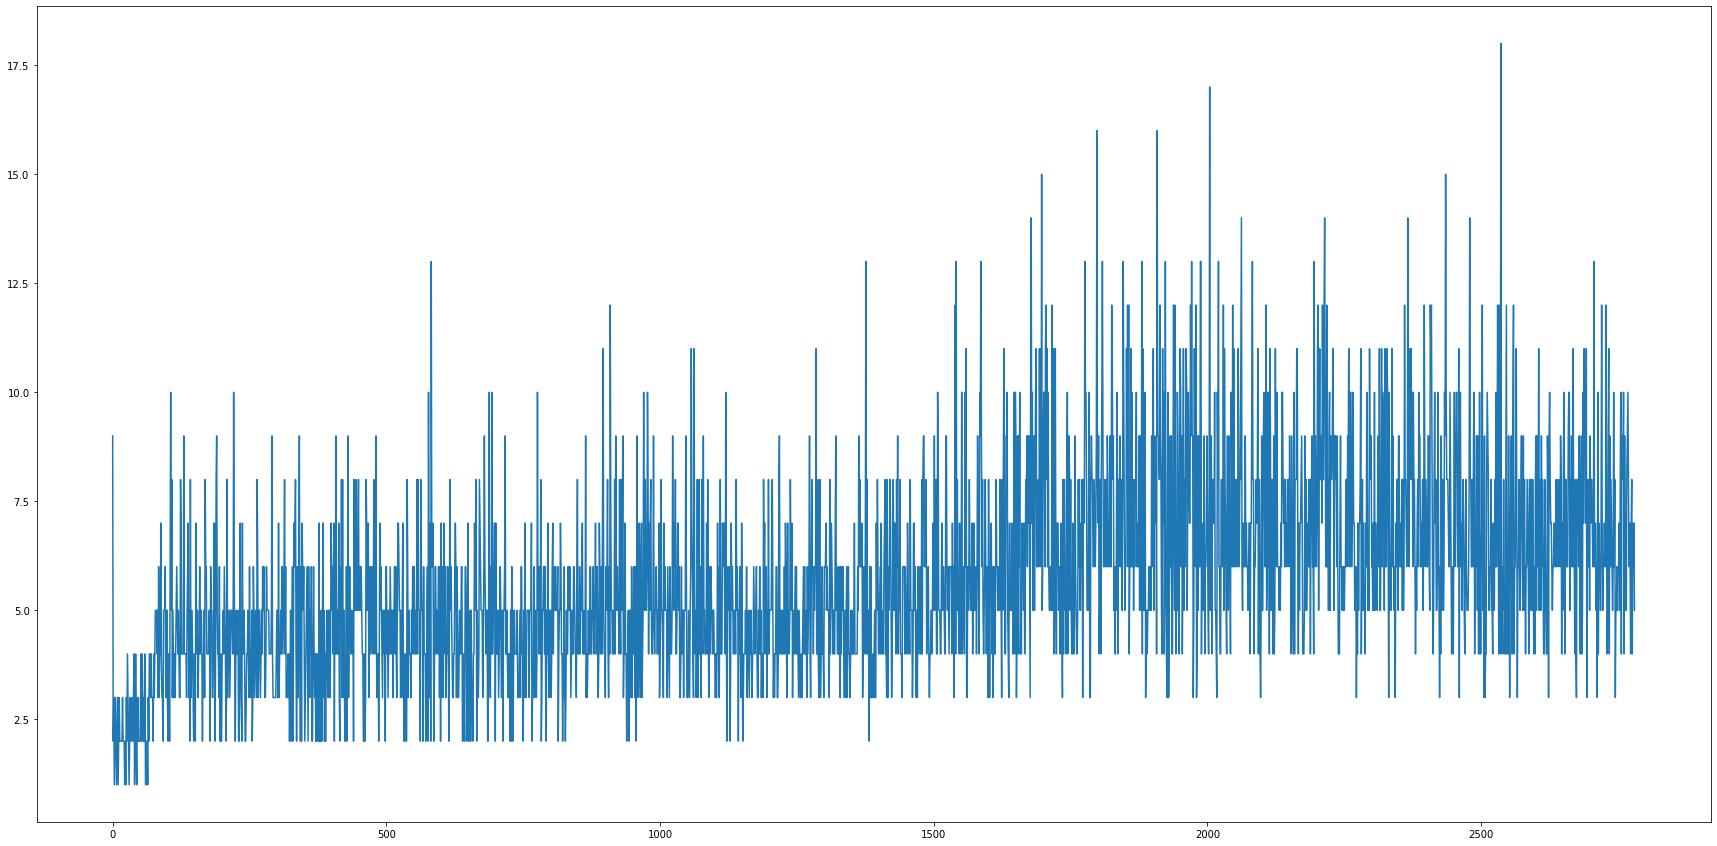

In [ ]:
plt.figure(figsize=(30, 15))
df["duration"].astype(int).plot()

### 2.2.3 Reward / episodios

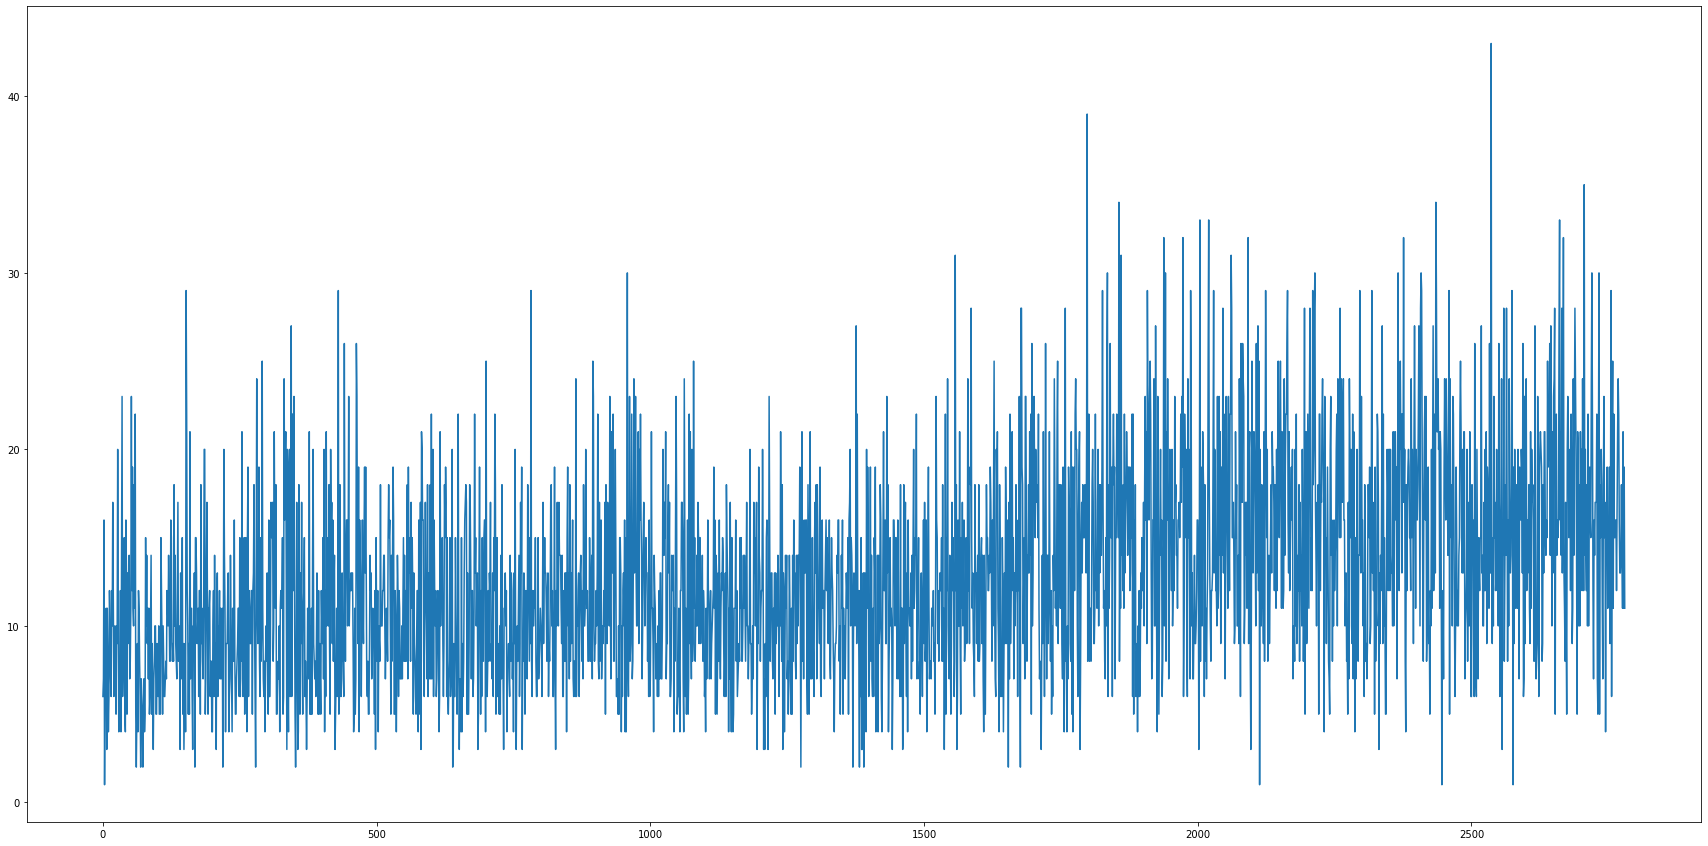

In [ ]:
plt.figure(figsize=(30, 15))
df["episode_reward"].astype(int).plot()

### 2.2.4 Q Value / episodios

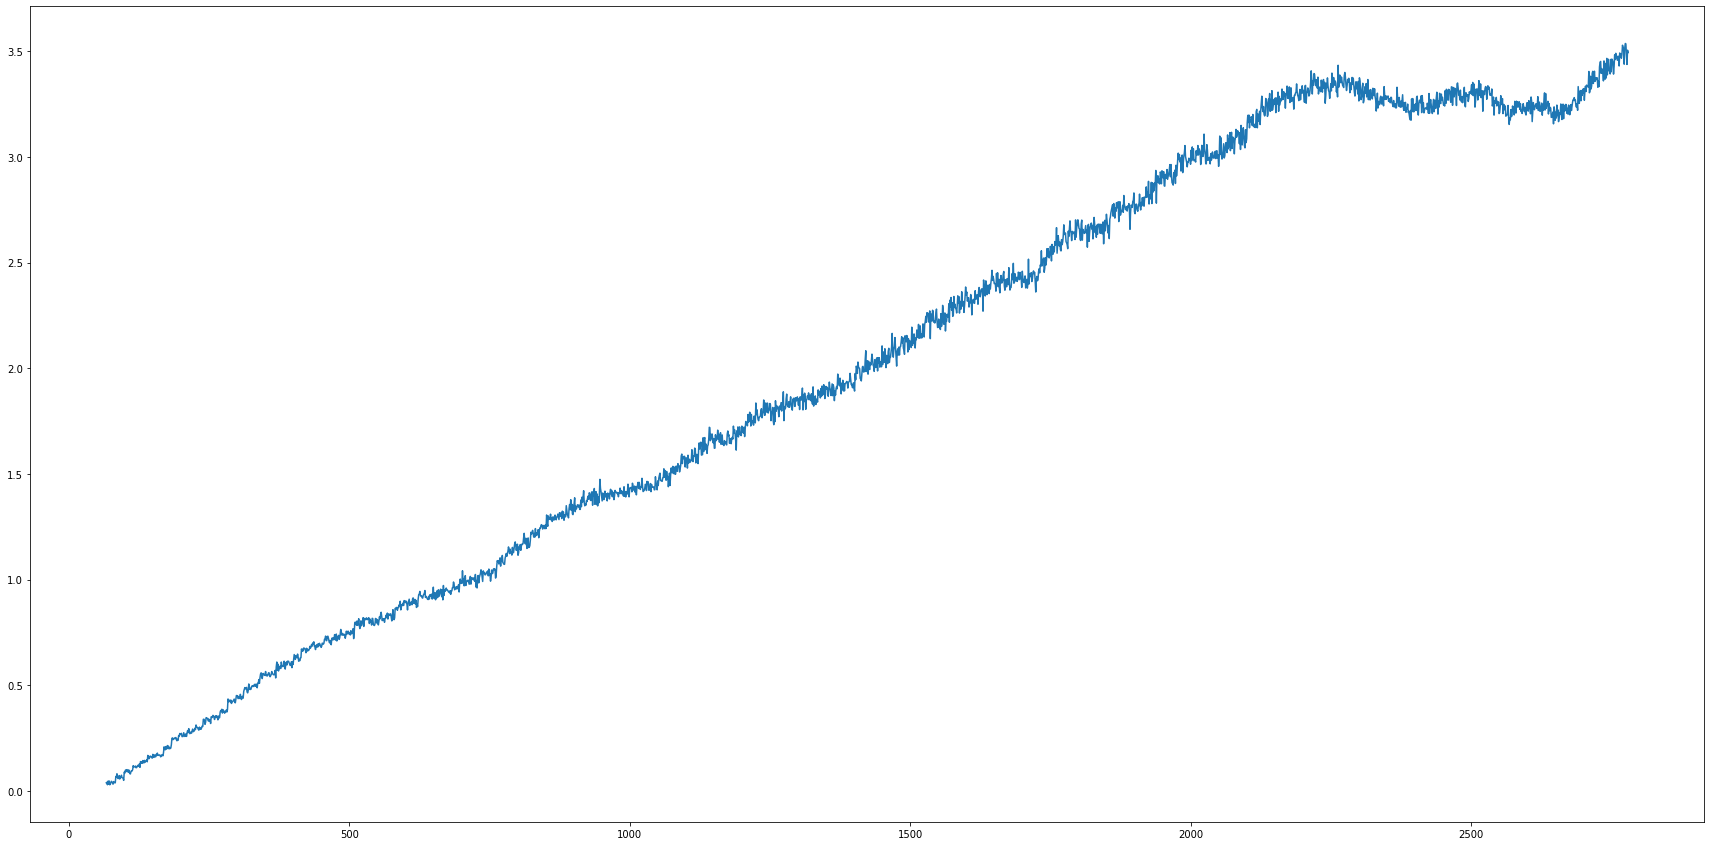

In [ ]:
plt.figure(figsize=(30, 15))
df["mean_q"].plot()

## 3. Justificación de los parámetros seleccionados y de los resultados obtenidos

### 3.1 Tabla de contenidos

La siguiente tabla muestra los diferentes experimentos realizados, teniendo en cuenta los hiperparámetros relacionados con el proceso de aprendizaje del agente:

| Network                                            	| Policy                          	| Steps totales 	| Exploracion 	| Explotacion 	| Learning Rate    	| Discount Rate 	| Target update 	| Warm up steps 	| Test min 	| Test max 	| Rate > 20 	|
|----------------------------------------------------	|---------------------------------	|---------------	|-------------	|-------------	|------------------	|---------------	|---------------	|---------------	|----------	|----------	|-----------	|
| CNN 3 layers + Dense=512 + output; padding='valid' 	| Epsilon-greedy                  	| 3000000       	| 2000000     	| 1000000     	| 0.00025          	| 0.9           	| 10000         	| 50000         	| 11       	| 25       	| 2/10      	|
| CNN 3 layers + Dense=512 + output; padding='valid' 	| Boltzmann                       	| 3000000       	| 2000000     	| 1000000     	| 0.00025          	| 0.99          	| 20000         	| 50000         	| 7        	| 21       	| 2/10      	|
| CNN 3 layers + Dense=128 + output; padding='same'  	| Epsilon-greedy                  	| 2000000       	| 1000000     	| 2000000     	| 0.00025          	| 0.99          	| 10000         	| 50000         	| 14       	| 31       	| 8/10      	|
| CNN 4 layers + Dense=512 + output; padding='valid' 	| Epsilon-greedy                  	| 2000000       	| 1200000     	| 800000      	| 0.0002 (Adam)    	| 0.9           	| 20000         	| 50000         	| 16       	| 28       	| 4/10      	|
| CNN 4 layers + Dense=512 + output; padding='valid' 	| Epsilon-greedy                  	| 2000000       	| 1000000     	| 1000000     	| 0.00025(RMSprop) 	| 0.9           	| 10000         	| 50000         	| 18       	| 24       	| 1/10      	|
| CNN 4 layers + Dense=512 + output; padding='valid' 	| Epsilon-greedy (value_test=.01) 	| 3000000       	| 2000000     	| 1000000     	| 0.00025(RMSprop) 	| 0.9           	| 10000         	| 50000         	| 17       	| 17       	| 0/10      	|
| CNN 4 layers + Dense=512 + output; padding='valid' 	| Epsilon-greedy                  	| 3000000       	| 2000000     	| 1000000     	| 0.00025(RMSprop) 	| 0.9           	| 10000         	| 50000         	| 5        	| 32       	| 1/10      	|

### 3.2 Conclusiones

* Basándonos en los experimentos realizados durante el proyecto, podemos sacar algunas conclusiones. En primer lugar, cabe destacar que durante el proyecto nos centramos especialmente en los parámetros relacionados con el aprendizaje por refuerzo y no tanto en la arquitectura final del modelo, aunque si realizamos ajustes sobre este para ver el efecto.
<br><br>
* En cuanto a la arquitectura del modelo, podemos destacar que, tal y como vemos en la tabla del apartado 3.1, el modelo que mejores resultados obtuvo fue el que tenia solo 128 neuronas en la capa densa final, comparados con las 512 que tuvimos en los demás. Lo que podría indicarnos que tener una capa densa de mayor tamaño requeriría un mayor número de steps de entrenamiento y por lo tanto estaría haciendo underfitting para la configuración que le dimos o que estamos intentando aproximar una función demasiado compleja para nuestro entorno.
<br><br>
* Otro dato que consideramos importante destacar fue que con un número mayor de steps (mayor a 2 millones), el rendimiento de nuestro modelo comenzaba a deteriorarse. Esto puede ser debido, al contrario que lo que comentamos en el punto anterior, a que podríamos estar haciendo overfitting sobre el conjunto de entrenamiento.
<br><br>
* Lo que pudimos observar, al menos en el entorno de la práctica, fue que nuestra policy no tenía un gran efecto en el resultado final. Es posible que al tratarse de un entorno sencillo, estas decisiones no tengan un impacto tan alto. Sin embargo, observamos que el `target update` sí que tuvo un efecto durante el entrenamiento.
<br><br>
* Como curiosidad, observamos que nuestro agente aprendió a disparar a la pelota roja que se encuentra en la parte superior de la pantalla del juego y que permite conseguir puntos extra! Lo cual es llamativo y demuestra el proceso de aprendizaje sobre el entorno de una manera "inteligente". Otro detalle del aprendizaje es observar al agente 'haciendo uso' de los escudos a fin de evitar ser alcanzado.